# Linear regression example

Data was taken from: https://www.kaggle.com/mirichoi0218/insurance

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import time

In [2]:
#Get data from csv file
data = pd.read_csv("LinearExample/insurance.csv") 
# Preview the first 5 lines of the loaded data 
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Check bmi distribution

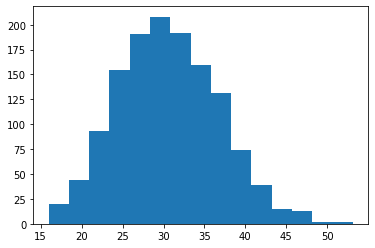

In [3]:
dataNp = data.to_numpy()
bmi = dataNp[:,2]
bmi = bmi.astype('float64')

plt.hist(bmi, bins=15)
plt.show()

### Check charges distribution

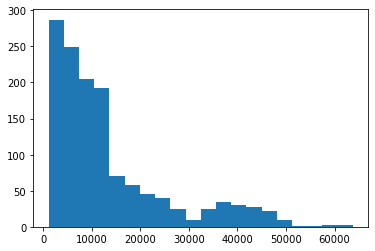

In [4]:
dataNp = data.to_numpy()

age = dataNp[:, 0]
age = age.astype('float64')
sex = dataNp[:, 1]
children = dataNp[:, 3]
charges = dataNp[:, 6]
charges = charges.astype('float64')


plt.hist(charges, bins=20)
plt.show()

### Checking relationship between age and charges

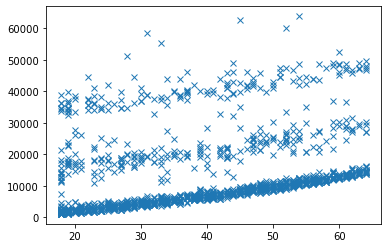

In [5]:
plt.plot(age, charges, 'x');

Checking plot, seems that there is a linear relation between these variables. It's very spreaded though.

Let's try to find a linear equation that fits this data just for fun.

With this visualization, 3 clusters are visible.
How do they relate with other variables?
How can I find the relation between a cluster and another variable(s)?

### Train the model with pytorch

In [6]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
#Get normalize values before spliting sets
ageNorm = np.linalg.norm(age)
chargesNorm = np.linalg.norm(charges)

#divide train and test dataset
X_train, X_test, y_train, y_test = train_test_split(age, charges, train_size=0.65,test_size=0.35)

#Get data sample sizes
trainDataSize = X_train.size
testDataSize = y_test.size

#normalize data
X_train =  X_train / ageNorm
X_test =  X_test / ageNorm
y_train = y_train / chargesNorm
y_test = y_test / chargesNorm

### Plot after normalization

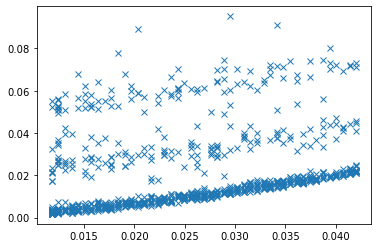

In [8]:
plt.plot(X_train, y_train, 'x');

### Use sklearn to train model and then plot calculated function and train data together

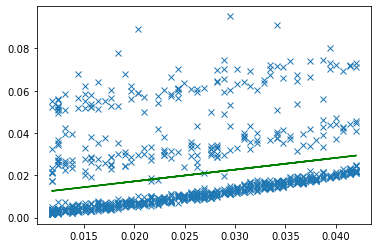

B0: [0.00602734], B1: [0.55501434]


In [9]:
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

beta0 = linr.intercept_
beta1 = linr.coef_[0]

yplot = X_train * beta1 + beta0

plt.plot(X_train, y_train, 'x');
plt.plot(X_train, yplot, 'g')
plt.show()

print(f'B0: {beta0}, B1: {beta1}')

### Use pytorch to train model

In [45]:
n_epochs = 400
batch_size_train = trainDataSize
batch_size_test = testDataSize
learning_rate = 0.01
momentum = 0.5
log_interval = 10

# transform to torch tensor
tensor_train_x = torch.Tensor(X_train.reshape(-1, 1))
tensor_train_y = torch.Tensor(y_train.reshape(-1, 1))

# create your datset
train_data = TensorDataset(tensor_train_x, tensor_train_y)

#Create loader using data
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size_train,
    shuffle=True)

# transform to torch tensor
tensor_test_x = torch.Tensor(X_test.reshape(-1, 1))
tensor_test_y = torch.Tensor(y_test.reshape(-1, 1))

# create your datset
test_data = TensorDataset(tensor_test_x, tensor_test_y)

#Create loader using data
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size_test,
    shuffle=True)

In [46]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)
    
#Network model
network = LayerLinearRegression()

#Configure loss function
LossFunction = nn.MSELoss(reduction='mean')

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.SGD(network.parameters(), lr=learning_rate)

In [47]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [48]:
def train(epoch):
  #Configure network for training
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    
    #set parameters gradients to 0
    optimizer.zero_grad()
    
    #runs model with data and returns result in output
    #here data contains a 64 * 1 * 28 * 28 tensor, 64 is batch size
    output = network(data)
    
    #Use negative log likelihood loss.
    loss = LossFunction(output, target)
    
    #with this gradients are calculated
    loss.backward()
    
    #update gradients
    optimizer.step()
    
    #Display iteration statistics
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), 'results/model.pth')
      #torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [49]:
def test():
  #Sets the module in evaluation mode
  network.eval()
  test_loss = 0
  correct = 0
    
  #dont update dynamic computation graph
  with torch.no_grad():
    #for every example in test
    for data, target in test_loader:
      #evaluate the model
      output = network(data)
        
      #acumulate the loss
      test_loss += LossFunction(output, target).item()
      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)
      #print('\nTest set: Avg. loss: {:.6f}\n'.format(test_loss))

In [50]:
#Check accuaracy before training
test()
tic = time.perf_counter()

for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
    
toc = time.perf_counter()

print(f"Time elapsed: {toc - tic:0.4f} seconds")

Train Epoch: 1 [0/869 (0%)]	Loss: 0.898456
Train Epoch: 2 [0/869 (0%)]	Loss: 0.862867
Train Epoch: 3 [0/869 (0%)]	Loss: 0.811516
Train Epoch: 4 [0/869 (0%)]	Loss: 0.754794
Train Epoch: 5 [0/869 (0%)]	Loss: 0.697864
Train Epoch: 6 [0/869 (0%)]	Loss: 0.643155
Train Epoch: 7 [0/869 (0%)]	Loss: 0.591702
Train Epoch: 8 [0/869 (0%)]	Loss: 0.543851
Train Epoch: 9 [0/869 (0%)]	Loss: 0.499613
Train Epoch: 10 [0/869 (0%)]	Loss: 0.458847
Train Epoch: 11 [0/869 (0%)]	Loss: 0.421345
Train Epoch: 12 [0/869 (0%)]	Loss: 0.386878
Train Epoch: 13 [0/869 (0%)]	Loss: 0.355217
Train Epoch: 14 [0/869 (0%)]	Loss: 0.326141
Train Epoch: 15 [0/869 (0%)]	Loss: 0.299442
Train Epoch: 16 [0/869 (0%)]	Loss: 0.274930
Train Epoch: 17 [0/869 (0%)]	Loss: 0.252425
Train Epoch: 18 [0/869 (0%)]	Loss: 0.231764
Train Epoch: 19 [0/869 (0%)]	Loss: 0.212796
Train Epoch: 20 [0/869 (0%)]	Loss: 0.195383
Train Epoch: 21 [0/869 (0%)]	Loss: 0.179396
Train Epoch: 22 [0/869 (0%)]	Loss: 0.164720
Train Epoch: 23 [0/869 (0%)]	Loss: 0.1512

Train Epoch: 193 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 194 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 195 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 196 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 197 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 198 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 199 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 200 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 201 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 202 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 203 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 204 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 205 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 206 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 207 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 208 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 209 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 210 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 211 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 212 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 213 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 214 [0/869 (0%)]	Loss: 0.000322
Train Epoc

Train Epoch: 380 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 381 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 382 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 383 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 384 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 385 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 386 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 387 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 388 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 389 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 390 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 391 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 392 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 393 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 394 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 395 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 396 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 397 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 398 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 399 [0/869 (0%)]	Loss: 0.000322
Train Epoch: 400 [0/869 (0%)]	Loss: 0.000322
Time elapsed: 7.9059 seconds


### Plot training result with pytorch

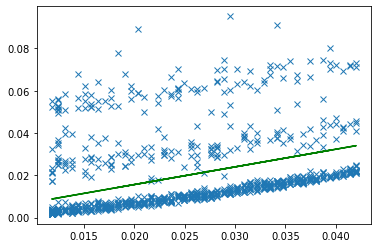

B0: [-0.00112463], B1: [[0.83635604]]


In [51]:
beta1, beta0 = network.parameters()

beta0 = beta0.data.numpy()
beta1 = beta1.data.numpy()

yplot = X_train * beta1 + beta0
plt.plot(X_train, y_train, 'x');
plt.plot(X_train, yplot.reshape(-1, 1), 'g')
plt.show()

print(f'B0: {beta0}, B1: {beta1}')

# References

https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817

# ToDo

- Loss is high, check if normalizing output helps.
- Model is converging now, but is still little bit different from sklearn
Options to do:
- Normalize outputs and train model again. Might no needed.
- What is the difference between a model and nn.Linear?
- Repair log output to display meaningful data

# Notes

Since data is very spread, using an small batch size the model doesn't seems to converge, if I use a bigger batch size, it does better.